<a href="https://colab.research.google.com/github/deancochran/SpotifyData/blob/master/DSC_Final_Lab_Predicting_the_Genre_of_a_Song.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load in the 'SpotifyFeatures' Spotify Dataset

Notice: 
Before this dataset can be used, it must be uploaded to the local colab notebook. (To do this... click the folder(file) icon on the right side of the screen, and click upload. Then upload the CSV file , 'SpotifyFeatures.csv' )
If this page is closed the data **MUST** be uploaded again

If the user of this notebook doesn't have access to the dataset, the file can be found at the following URL address
https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db



# Spotify Data Analysis 
By: Dean Cochran



# Goal

**To become an effective data scientist, you need extensive practice modeling and analyzing real world relationships. In this anlysis I hope to highlight the relationship between Spotify's audio features and its genre.**

In other words, I hope find the best model to predict the genre of a single single song using various machine learning classification algorithms.



# Abstract


> In this analysis I follow the Data Science LifeCycle that we focused on master this semester. I explore the data that we to understand the domain of my dataset. This allows to pull more meaningful conclusions from my results. I prepare my data as apart of the 'Data Prepartion' stage by manipulating the data I explored to get ready to plan my classifying models I want to use it this lab. I build the models and tune the hyper-parameters to find the best possible model for classifying a songs genre. Finally I "bag" all the useful models in my results and create another model which is a collection of al models and analyze its reults. 




# Imports

In [0]:
##IMPORTS REQUIRED FOR DATA MANIPULATION AND EXPXLORATION
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

##IMPORTS FOR BUILDING MODELS and TUNING HYPERPARAMETERS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

##IMPORTS FOR ANALYSIS OF MODELS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

# LOADING IN DATA

In [0]:
spotify = pd.read_csv("SpotifyFeatures.csv")

Before assuming anything about our data, lets take a look at the dataset

In [0]:
spotify

genre               artist_name  ... time_signature valence
0       Movie            Henri Salvador  ...            4/4   0.814
1       Movie         Martin & les fées  ...            4/4   0.816
2       Movie           Joseph Williams  ...            5/4   0.368
3       Movie            Henri Salvador  ...            4/4   0.227
4       Movie              Fabien Nataf  ...            4/4   0.390
...       ...                       ...  ...            ...     ...
232720   Soul                     Slave  ...            4/4   0.962
232721   Soul  Jr Thomas & The Volcanos  ...            4/4   0.969
232722   Soul              Muddy Waters  ...            4/4   0.813
232723   Soul                   R.LUM.R  ...            4/4   0.489
232724   Soul            Mint Condition  ...            4/4   0.479

[232725 rows x 18 columns]

In [0]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

Here are some things you should notice after looking at the data...

*   **WOW, that's a lot of data**
*   This gives us a great visual of the full dataset could look like.
*   There's a lot of information that I can't interpret
*   What do all these features mean



To address all of these initial preceptions, lets first address what all of our feature values mean
*   genre:  a category of artistic composition
*   artist_name:  the name of the artist
*   track_name: the name of the song
*   track_id: the Spofity Id of the song (every song has a unique id)
*   popularity: the spotify's rating of popularity (range:[1,100])
*   acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
*   danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
*   duration_ms: the length of the song measure in milli-seconds
*   Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
*   instrumentalness: Predicts whether a track contains no vocals.
*   key: the key the song is played in
*   liveness: Detects the presence of an audience in the recording. 
*   Loudness: 	The overall loudness of a track in decibels (dB). 
*   mode: wether the song is played in a minor or major chord
*   speechiness: Speechiness detects the presence of spoken words in a track. 
*   tempo: the pace at which the song is played at
*   time signature: the signature the pace of the song is played at
*   valence: 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. 



# Lets Explore the Data
I want to know what parts of this data are missing, and what parts of this data I need to manipulate inorder to verify that the data is 'clean'

To do this I wrote a helper function which will parse through my data and 'explore' for me....

In [0]:
# helper function to investigate issues with dataset
def explore(dataset):
  woDup = dataset.drop_duplicates(keep = 'first', inplace = False)
  print("There are", len(dataset) - len(woDup), "duplicate rows in this dataset.")
  print("")

  ## feature names ?  
  stats = dataset.count(level=None)
  names = stats.index
  print("There are", len(list(names)), "columns in the dataset.")
  print("")

  ## missing data ?
  total = stats[0]
  missing  = {"Column Name":[],"% Missing":[]}
  for i in range(1,len(names)):
    missNum = total - stats[i]
    p = missNum / total
    missing['% Missing'].append(p * 100)
    missing['Column Name'].append(names[i])
  missing = pd.DataFrame(data=missing)
  tops = missing.sort_values(by=['% Missing'], ascending = False)
  print(tops)
  print("")
  print("Consider scaling data for modeling.")
  return 

In [0]:
explore(spotify)

There are 0 duplicate rows in this dataset.

There are 18 columns in the dataset.

         Column Name  % Missing
0        artist_name        0.0
9                key        0.0
15    time_signature        0.0
14             tempo        0.0
13       speechiness        0.0
12              mode        0.0
11          loudness        0.0
10          liveness        0.0
8   instrumentalness        0.0
1         track_name        0.0
7             energy        0.0
6        duration_ms        0.0
5       danceability        0.0
4       acousticness        0.0
3         popularity        0.0
2           track_id        0.0
16           valence        0.0

Consider scaling data for modeling.


In [0]:
spotify.genre.value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

**Notice that the instances of each genre are not balanced. We need to change this later**

**Check for duplicates Again... Somethings off**

Each row of this data represents a song. However, there are songs that labelled into multiple genre. Take a look at this data

In [0]:
df=spotify.copy()

In [0]:
##IDENTIFYING SONGS OF THE SAME TRACK_ID
duplicated_all = df[df.duplicated(subset = 'track_id', keep=False)]
duplicated = df[df.duplicated(subset = 'track_id', keep='first')]
df[df['track_id'] == duplicated['track_id'].iloc[0]]

genre artist_name  ... time_signature valence
257                  R&B    Doja Cat  ...            4/4     0.7
1348         Alternative    Doja Cat  ...            4/4     0.7
77710   Children’s Music    Doja Cat  ...            4/4     0.7
93651              Indie    Doja Cat  ...            4/4     0.7
113770               Pop    Doja Cat  ...            4/4     0.7

[5 rows x 18 columns]

**Alright... Well thats not a great sign**

Imagine, if you're going to classify same data characterisics over a different classes. Isn't that frustating to you ? Well, this goes the same with our model later. This is current limitation of spotify dataset.

In [0]:
### PRINTS AMOUNT OF DUPLICATES (SONGS THAT SHARE THE SAME TRACK ID)
print(f''''Unique Duplicates: {duplicated.shape[0]}
Total Duplicates: {duplicated_all.shape[0]}
Total Data: {spotify.shape[0]}
Duplicates %: {round(duplicated_all.shape[0]/spotify.shape[0]*100, 2)}''')

'Unique Duplicates: 55951
Total Duplicates: 91075
Total Data: 232725
Duplicates %: 39.13


**Imagine how bad is our model will perform on this type of dataset that contains total 39% of duplicates. For now, let's just use the data as it is.**

While this is fine, I will still need to manipulate the columns to make the data for computer friendly. There seems to be too much information in the wrong format

# What else can we find out about the data

Let's make some visuals...

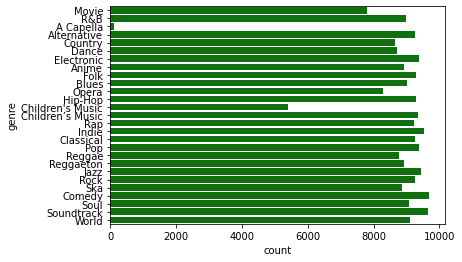

In [0]:
sns.countplot(y="genre", data=spotify, color='green')

Based on the class frequency, there's a huge different of value in A Capella. A Capella only makes up 0.05% of the data. We will later see the effect of imporving our model by removing this class label from our dataframe

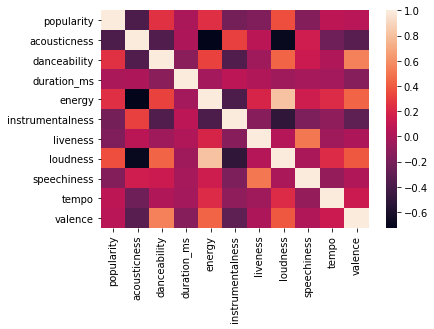

In [0]:
sns.heatmap(spotify.corr())

**Here we have a correlation matrix which allows us to identify if any of the features have a significant relationship.**

# **DATA PREP**

Now that we've had a better look at the information that we've found, lets take that information and use it to form some classifiers.

Before we being our data preparation, lets create a deep copy of our dataframe, that way we will have an original data set and a new dataframe that will can manipulate.

In [0]:
df=spotify.copy()
#df is our new dataframe
df.head()

genre        artist_name  ... time_signature valence
0  Movie     Henri Salvador  ...            4/4   0.814
1  Movie  Martin & les fées  ...            4/4   0.816
2  Movie    Joseph Williams  ...            5/4   0.368
3  Movie     Henri Salvador  ...            4/4   0.227
4  Movie       Fabien Nataf  ...            4/4   0.390

[5 rows x 18 columns]

**Notice that the class label 'A Capella'. is not well represented in our data, and therefore we will not be able to accuractly predict the a song that can be considered to be A Capella.**

**We will need to remove all instances of songs that are A Capella**

In [0]:
#REMOVES A CAPELLEA GENRE FROM DF
df = df[df['genre'] != 'A Capella']

**Notice that some target variable values in our data are have the same name but are not labeled the same**

Take a look at the unique values in our genre series... Notice that Children's Music is found twice...

*Notice the apostrophe in the two phrases* The apostrophe in the two words are different! That sucks! Now we will have to use the replace() function to rename all the children's muisic values

In [0]:
#REPLACES 2 DIFFERENT GENRE TITLES WITH 1 COMMON LABEL
df.genre=df.genre.replace({"Children's Music": "Children's Music"})
df.genre=df.genre.replace({"Children’s Music": "Children's Music"})
####################################^#############################
###########Notice the difference in the apostrophes###############

**Notice that some target variable values in our data are have symbols that can be harmful to the model building process later in this lab**

Lets rename all of the values in the genre series that we don't want... (R&B, Hip-Hop)

In [0]:
#REPLACES 2 UNPARSABLE GENRE TITLES WITH 1 COMMON LABEL
df.genre=df.genre.replace({'R&B': 'RnB'})
df.genre=df.genre.replace({'Hip-Hop': 'HipHop'})

In [0]:
df.genre.unique()

array(['Movie', 'RnB', 'Alternative', 'Country', 'Dance', 'Electronic',
       'Anime', 'Folk', 'Blues', 'Opera', 'HipHop', "Children's Music",
       'Rap', 'Indie', 'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz',
       'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack', 'World'],
      dtype=object)

**Notice that some non target variable values in our data are unique to a specific genre**

Because of this, our machine learning models will not be able to accurately and precisely predict our target outcome genre. 

In order to fix this we will need to remove all non-target variables, whos feature values have unique information to a singleular song will need to be removed.

In [0]:
##REMOVES IDENTIFIER FEATURES
columns_to_drop=['artist_name','track_name','track_id',]
df=df.drop(columns=columns_to_drop)

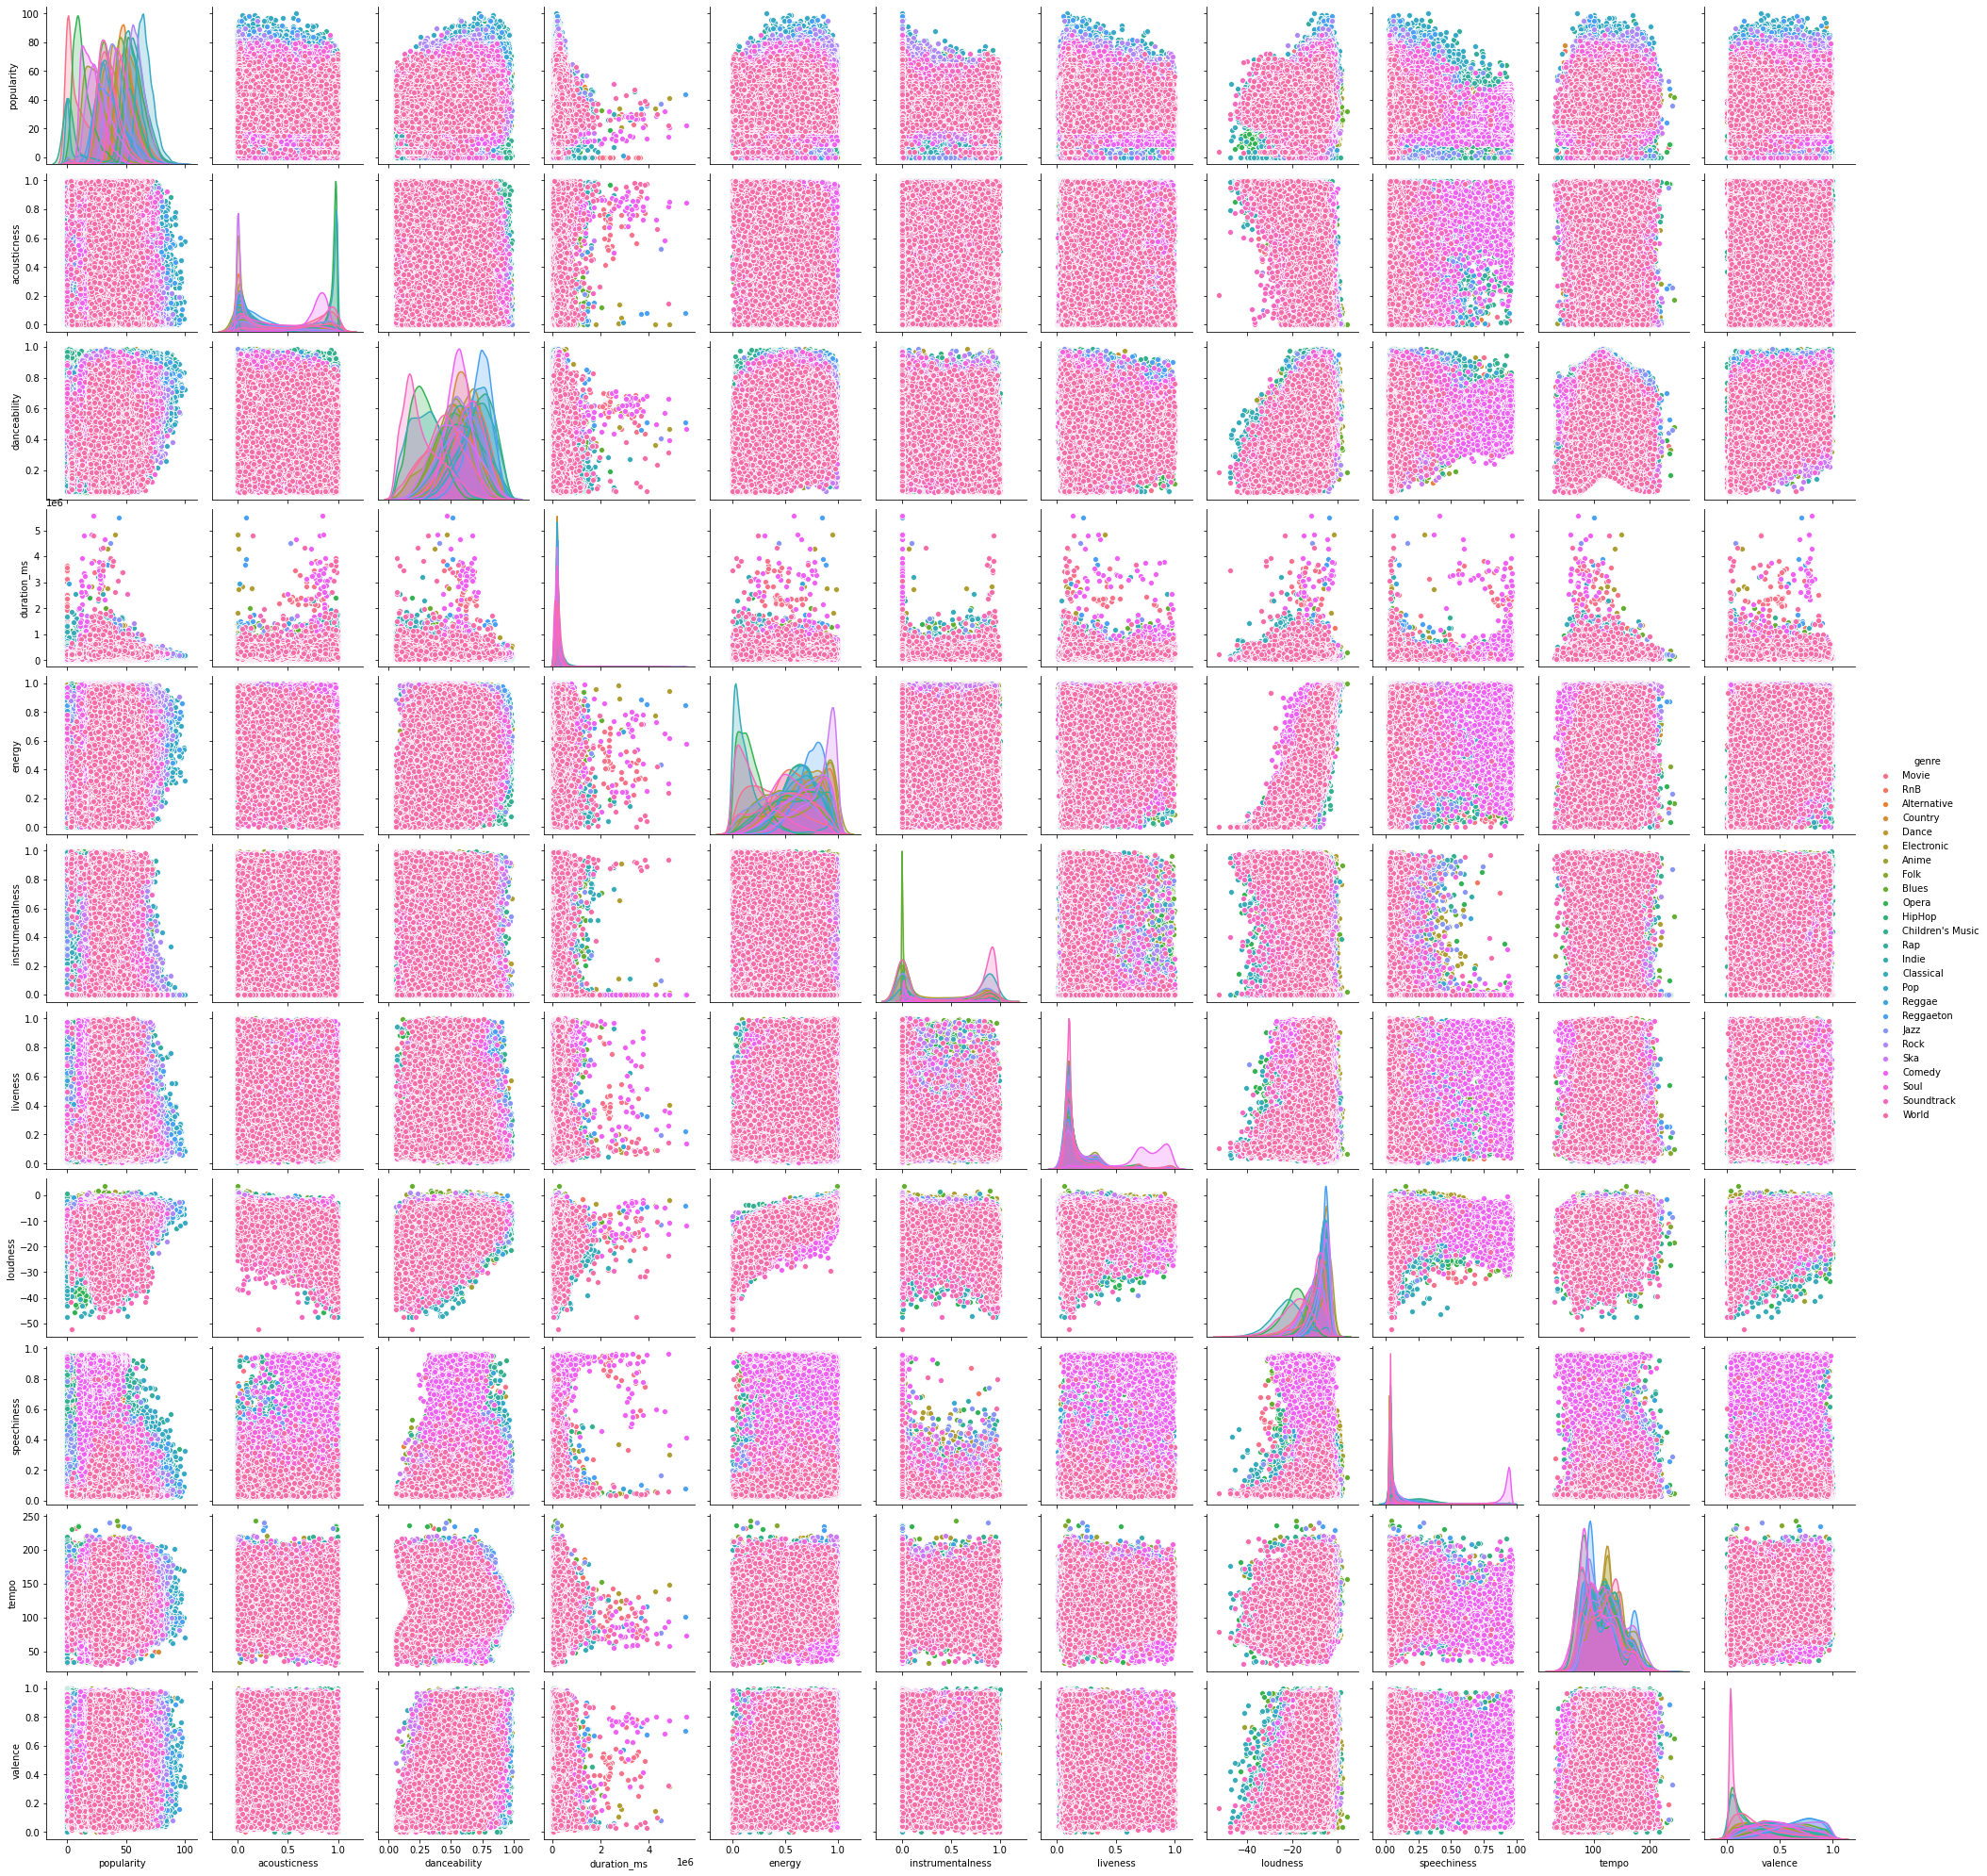

In [0]:
sns.pairplot(df, hue="genre",palette="husl") 

**Notice that there is an imbalance of genre instances as show in the exploration of our dataframe. We will nee to rebalance the dataset by removing any instances of genres that exceed the genre whose class label is lest expressed in the data**

In [0]:
def rebalance(data):
    from tqdm import tqdm
    # set maximum occurence of data to the genre whose 
    #class label is lest expressed in the data (Movie: 5400)
    max_val = 7800 
    # create new dataframe 
    _data = pd.DataFrame(columns=data.columns)
    
    # iteratively add sample of songs based on depandent variable class 
    for genre in tqdm(data['genre'].unique()):
        _data = _data.append(data[data['genre'] == genre].sample(n=max_val, random_state=1), ignore_index=True, sort=False)  
    return _data

df=rebalance(df)

100%|██████████| 25/25 [00:01<00:00, 20.78it/s]


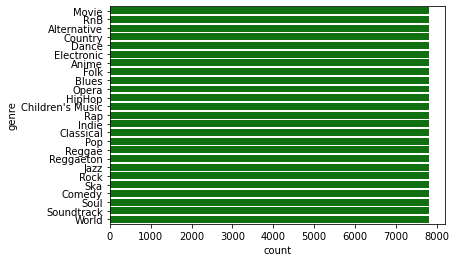

In [0]:
sns.countplot(y="genre", data=df, color='green')

****Notice that our feature values are not all in the same format. We will need to binarize categorical and discrete data found in our feature values**

Since our data is not all in the same format, our classification methods will become useless in interpretting the significance of the difference between; for example, the key C# and F#. The only way for the computer identify differences is by numbers. 

This is why we must label the categorical variables (genre, mode) and one hot encode descrete varibales (key and time-signature).

To label our information we will use a simple label encoder to identifty 2 values. 
To identify more than two values we will use the one-hot encoding method from sklearn.

**Notice:** This will cause our program to create an ID of genres... Becuase the Label Encoder works in alphabetical order, we can create a personalized user friendly legend right here

In [0]:
genres=df.genre.unique()
genres

array(['Movie', 'RnB', 'Alternative', 'Country', 'Dance', 'Electronic',
       'Anime', 'Folk', 'Blues', 'Opera', 'HipHop', "Children's Music",
       'Rap', 'Indie', 'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz',
       'Rock', 'Ska', 'Comedy', 'Soul', 'Soundtrack', 'World'],
      dtype=object)

In [0]:
##CREATES A LEGEND FOR THE GENRE LABELS WE WILL EVENTUALLY PREDICT
values=sorted(genres)
keys=np.arange(0, len(genres)).tolist()

genre_legend= {}

count=0
for i in keys:
  genre_legend[i]=genres[count]
  count=count+1

In [0]:
genre_legend

{0: 'Movie',
 1: 'RnB',
 2: 'Alternative',
 3: 'Country',
 4: 'Dance',
 5: 'Electronic',
 6: 'Anime',
 7: 'Folk',
 8: 'Blues',
 9: 'Opera',
 10: 'HipHop',
 11: "Children's Music",
 12: 'Rap',
 13: 'Indie',
 14: 'Classical',
 15: 'Pop',
 16: 'Reggae',
 17: 'Reggaeton',
 18: 'Jazz',
 19: 'Rock',
 20: 'Ska',
 21: 'Comedy',
 22: 'Soul',
 23: 'Soundtrack',
 24: 'World'}

**Label Genre (TARGET VARIABLE) with Label Encoder**

In [0]:
#Label Encoding Mode in alphabetical order
encoder=LabelEncoder()
df['genre']=encoder.fit_transform(df['genre'])

**Label Mode with Label Encoder**

In [0]:
#Label Encoding Mode in alphabetical order
encoder=LabelEncoder()
df['mode']=encoder.fit_transform(df['mode'])


**One-Hot Encode Key and Time-Signature**

In [0]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['key'], prefix='key')],axis=1)
# now drop the original 'country' column (you don't need it anymore)
df.drop(['key'],axis=1, inplace=True)

# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['time_signature'], prefix='key')],axis=1)
# now drop the original 'country' column (you don't need it anymore)
df.drop(['time_signature'],axis=1, inplace=True)


In [0]:
df

genre popularity  acousticness  ...  key_3/4 key_4/4  key_5/4
0          13          0      0.110000  ...        0       1        0
1          13         41      0.876000  ...        1       0        0
2          13         23      0.025000  ...        0       1        0
3          13          1      0.666000  ...        0       1        0
4          13         25      0.250000  ...        0       1        0
...       ...        ...           ...  ...      ...     ...      ...
194995     24         41      0.661000  ...        1       0        0
194996     24         27      0.000097  ...        0       1        0
194997     24         41      0.408000  ...        0       1        0
194998     24         26      0.708000  ...        0       1        0
194999     24         47      0.045000  ...        0       1        0

[195000 rows x 30 columns]

**Great, now for the final part of our preparation for our data.**

Since each column is not all expressed in the same means of units, we will need to normalize, or scale our entire dataframe.

We have many options, however there seemes to be one that would be best suited for this situation. The MinMaxScaler.

In [0]:
#HELPER FUNCTION TO SCALE DATAFRAME
def scaleColumns(df, cols_to_scale):
    min_max_scaler = MinMaxScaler()
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [0]:
#scaleColumns(df, cols_to_scale) <- syntax example
scaleColumns(df, df.columns[1:])

genre  popularity  acousticness  ...  key_3/4  key_4/4  key_5/4
0          13        0.00      0.110442  ...      0.0      1.0      0.0
1          13        0.41      0.879518  ...      1.0      0.0      0.0
2          13        0.23      0.025100  ...      0.0      1.0      0.0
3          13        0.01      0.668675  ...      0.0      1.0      0.0
4          13        0.25      0.251004  ...      0.0      1.0      0.0
...       ...         ...           ...  ...      ...      ...      ...
194995     24        0.41      0.663655  ...      1.0      0.0      0.0
194996     24        0.27      0.000098  ...      0.0      1.0      0.0
194997     24        0.41      0.409639  ...      0.0      1.0      0.0
194998     24        0.26      0.710843  ...      0.0      1.0      0.0
194999     24        0.47      0.045181  ...      0.0      1.0      0.0

[195000 rows x 30 columns]

**BOOOM! DATA PREP DONE!** (i hope)

We successfully, converted all values in the data frame to identifiable values between the integers 0,1. 

That is a great portion of the project out of the way.

In [0]:
df

genre  popularity  acousticness  ...  key_3/4  key_4/4  key_5/4
0          13        0.00      0.110442  ...      0.0      1.0      0.0
1          13        0.41      0.879518  ...      1.0      0.0      0.0
2          13        0.23      0.025100  ...      0.0      1.0      0.0
3          13        0.01      0.668675  ...      0.0      1.0      0.0
4          13        0.25      0.251004  ...      0.0      1.0      0.0
...       ...         ...           ...  ...      ...      ...      ...
194995     24        0.41      0.663655  ...      1.0      0.0      0.0
194996     24        0.27      0.000098  ...      0.0      1.0      0.0
194997     24        0.41      0.409639  ...      0.0      1.0      0.0
194998     24        0.26      0.710843  ...      0.0      1.0      0.0
194999     24        0.47      0.045181  ...      0.0      1.0      0.0

[195000 rows x 30 columns]

# **Model Prepartions**
**The next step in our anlysis is to split the data**

Typically, this is done after the models have been created and are ready to be fit, however seeing that we will be testing multiple models, we will need our data to be separated into 3 partitions; Train, Validation and test sets

Sets:

1.   Train (60% of our data)
2.   Validation (20% of our data)
3.   Test (20% of our data)

Each set with be separated by predictor and outcome variables. Therefore we need to create 6 datasets.

1.   yTrain
2.   xTrain
3.   yValidation
4.   xValidation
5.   yTest
6.   xTest




In [0]:
#HELPER FUNCTION TO SPLIT DATA INTO TRAIN, VALIDATION, and TEST SETS
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    #TELLS PARSER WHEN TO STOP ADDING TO THE TRAIN SET
    train_end = int(train_percent * m)
    #TELLS PARSER WHEN TO STOP ADDING TO THE VALIDATE SET
    validate_end = int(validate_percent * m) + train_end
    #CREATES NEW DF FROM START OF DF TO END OF TRAIN SET
    train = df.iloc[perm[:train_end]]
    #CREATES NEW DF FROM START OF DF TO END OF VALIDATE SET
    validate = df.iloc[perm[train_end:validate_end]]
    #CREATES NEW DF FROM START OF DF TO END OF TEST SET
    test = df.iloc[perm[validate_end:]]
    #RETURNS ALL DFs
    return train, validate, test

In [0]:
train, validate, test = train_validate_test_split(df)

**Lets validate that this helper function worked and appears to be partitioning the data correctly**

In [0]:
train.count

<bound method DataFrame.count of         genre  popularity  acousticness  ...  key_3/4  key_4/4  key_5/4
149404     20        0.69      0.676707  ...      0.0      1.0      0.0
188883     24        0.42      0.005271  ...      0.0      1.0      0.0
167953      5        0.23      0.974900  ...      1.0      0.0      0.0
71766      14        0.10      0.961847  ...      0.0      1.0      0.0
119158     15        0.67      0.069880  ...      0.0      1.0      0.0
...       ...         ...           ...  ...      ...      ...      ...
34453       7        0.63      0.287149  ...      0.0      1.0      0.0
85732      10        0.48      0.118474  ...      0.0      1.0      0.0
27203       6        0.39      0.283133  ...      0.0      1.0      0.0
60403       9        0.41      0.959839  ...      1.0      0.0      0.0
122164     15        0.73      0.696787  ...      0.0      1.0      0.0

[117000 rows x 30 columns]>

In [0]:
validate.count

<bound method DataFrame.count of         genre  popularity  acousticness  ...  key_3/4  key_4/4  key_5/4
24938       6        0.55      0.783133  ...      0.0      1.0      0.0
100928     16        0.62      0.088052  ...      0.0      1.0      0.0
90582       3        0.48      0.000005  ...      0.0      1.0      0.0
136895     18        0.36      0.125502  ...      0.0      1.0      0.0
77542      14        0.05      0.959839  ...      0.0      1.0      0.0
...       ...         ...           ...  ...      ...      ...      ...
143639     12        0.39      0.982932  ...      1.0      0.0      0.0
98548      16        0.69      0.011948  ...      0.0      1.0      0.0
179881     23        0.41      0.940763  ...      0.0      1.0      0.0
49355       1        0.27      0.055221  ...      0.0      1.0      0.0
99650      16        0.72      0.616466  ...      0.0      1.0      0.0

[39000 rows x 30 columns]>

In [0]:
test.count

<bound method DataFrame.count of         genre  popularity  acousticness  ...  key_3/4  key_4/4  key_5/4
20104       0        0.58      0.000820  ...      0.0      1.0      0.0
169948      5        0.20      0.949799  ...      0.0      1.0      0.0
174689     22        0.57      0.027209  ...      0.0      1.0      0.0
53729       1        0.30      0.996988  ...      0.0      1.0      0.0
24192       6        0.39      0.054719  ...      0.0      1.0      0.0
...       ...         ...           ...  ...      ...      ...      ...
116343      4        0.36      0.998996  ...      1.0      0.0      0.0
102115     11        0.55      0.104418  ...      0.0      1.0      0.0
5307       13        0.14      0.913655  ...      1.0      0.0      0.0
65574       2        0.28      0.020181  ...      0.0      1.0      0.0
56597       9        0.52      0.021084  ...      0.0      1.0      0.0

[39000 rows x 30 columns]>

**Now that we know our data is partitioned correctly, lets create our train, validation, and test x/y sets**

In [0]:
#SPLITS TRAIN/VALIDATE/TEST SET IN TO CLASS LABELS AND PREDICTOR FEATURES
ytrain=train['genre']
xtrain=train.drop(columns='genre')

yvalidate=validate['genre']
xvalidate=validate.drop(columns='genre')

ytest=test['genre']
xtest=test.drop(columns='genre')

# **Building our Models**

Now we can decide what models we want to use!

Note: Our goal is to find the best model to predict the genre of a single single song using various machine learning classification algorithms.

Aftering taking a look at our goal of the project one more time, it is clear that we will be using as many classification algorithms as we see fit. We will analyze each of them and then select the best model.

Let's use all of the most common classification models:
 'KNeighborsClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'LogisticRegression'

All of these are very common and will serve our purpose in finding the best model to predict the genre of a song.

## **Lets also use a grid search to tune our hyperparameters**
This will not be time efficent, this will take a minute, but it will find the best result

**Building KNeighbors Classifer model**

In [0]:
#KNN Classifier with GRIDSEARCH to find the best hyperparamters

hyperparameters = {'n_neighbors':(2,8,15)}

knn=KNeighborsClassifier()
knn=GridSearchCV(knn, hyperparameters)
knn.fit(xtrain,ytrain.values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

**Building Decision Tree Classifer model**

In [0]:
#DT Classifier with GRIDSEARCH to find the best hyperparamters

hyperparameters = {'min_samples_leaf':(1,5,10)}


dt=DecisionTreeClassifier(min_samples_leaf=1)
dt=GridSearchCV(dt, hyperparameters)
dt.fit(xtrain,ytrain.values.reshape(-1,1))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Building Random Forest Classifer model**

In [0]:
#RF Classifier with GRIDSEARCH to find the best hyperparamters

hyperparameters = {'n_estimators':(100,500)}

rf=RandomForestClassifier(n_estimators=100)
rf=GridSearchCV(rf, hyperparameters)
rf.fit(xtrain,ytrain.values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Building Logistic Regression Classifer model**

In [0]:
#LOG REG Classifier with GRIDSEARCH to find the best hyperparamters

hyperparameters = {'max_iter':(1000,2000)}

lgr=LogisticRegression(multi_class='multinomial', max_iter=1000)
lgr=GridSearchCV(lgr, hyperparameters)
lgr.fit(xtrain,ytrain.values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
models=[knn,dt,rf,lgr]
model_names=['KNN','DT','RF','LGR']

**Now that all of our models ahve been fit, lets predict our validation sets so we can see the accuracy of each model**

In [0]:
#FOR EACH FIT MODEL INSIDE THE "MODELS" ARRAY WE COMPUTE THEIR ACCURACY SCORE
count=0
for model in models:
  ypred=model.predict(xvalidate)
  print(model_names[count]+' Accuracy Percentage: '+str(round(accuracy_score(yvalidate,ypred),2)))
  count=count+1
  

KNN Accuracy Percentage: 0.29
DT Accuracy Percentage: 0.29
RF Accuracy Percentage: 0.39
LGR Accuracy Percentage: 0.37


# **Initial analysis of our best classifer model**

**From our results we can determine that the Random Forest classifier was the best of our initial models!**

**Lets take a look at the calssificaiton results from the Random Forest Classifier**

*Accuracy can be a useful measure if we have the same amount of samples per class but if we have an imbalanced set of samples accuracy isn't useful at all. Even more so, a test can have a high accuracy but actually perform worse than a test with a lower accuracy.*

**This being said the overall accuracy of the Random Forest Classifier was higher than all other classifiers with an Accuracy of 40%**


*A good F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0.*

**This being said the  F1-score for each of the outcome labels after being predicted and compared to the validation set, using the Random Forest Classifier can be seen below**

In [0]:
##TAKES A LOOK AT THE CLASSIFICATION REPORT FOR OUR BEST MODEL
ypred=rf.predict(xvalidate)
print(classification_report(yvalidate,ypred))

              precision    recall  f1-score   support

           0       0.17      0.16      0.16      1556
           1       0.63      0.56      0.59      1592
           2       0.39      0.41      0.40      1603
           3       0.29      0.22      0.25      1506
           4       0.61      0.60      0.61      1511
           5       0.98      0.93      0.95      1535
           6       0.37      0.43      0.40      1523
           7       0.15      0.14      0.14      1571
           8       0.51      0.53      0.52      1584
           9       0.21      0.22      0.21      1620
          10       0.18      0.21      0.19      1553
          11       0.07      0.06      0.07      1604
          12       0.39      0.35      0.37      1602
          13       0.62      0.64      0.63      1557
          14       0.75      0.86      0.80      1502
          15       0.15      0.18      0.16      1548
          16       0.11      0.11      0.11      1554
          17       0.45    

In [0]:
genre_legend

{0: 'Movie',
 1: 'RnB',
 2: 'Alternative',
 3: 'Country',
 4: 'Dance',
 5: 'Electronic',
 6: 'Anime',
 7: 'Folk',
 8: 'Blues',
 9: 'Opera',
 10: 'HipHop',
 11: "Children's Music",
 12: 'Rap',
 13: 'Indie',
 14: 'Classical',
 15: 'Pop',
 16: 'Reggae',
 17: 'Reggaeton',
 18: 'Jazz',
 19: 'Rock',
 20: 'Ska',
 21: 'Comedy',
 22: 'Soul',
 23: 'Soundtrack',
 24: 'World'}

**From the combined results of our calssification report it is clear to see that the Random Tree Classifier**

**Can not identify songs of the following genres (F1-score<.2):**
0.   Movie
7.   Folk
11.   Children's Music
16.   Reggae
19.   Rock
22.  Soul


# **My speculation as to why the models can not accurately predict genre**

**For only running the validation set my results are good! That is, my models can work coirrectly and can predict some songs correctly. But why can't they predict all songs**

In short, I hypothesize I believe that some genres have features whose distributions are **similar or identical** to other genre's feature distributions. 

In turn, I also hypothesize that some genres have features whose distributions are **very different** than other genre's feature distributions. 

# However, the most important factor in all of this information is to remember...

The dataset we are predicting is full of duplicates! Up to 39% of all the initial dataset was a duplicate.

**The #1 issue with our predictions is that our models are trying to predict the genre of a song, that has multiple genres!!!**

# **My solution to the issue in our data:**

Instead of predicting 1 genre, for a song that fits in many different genres. We should predict the top 'n' genres, where n is a # of predictions a model can make. 

This way the model will be able to make a variety of guesses without being confused about how a single song can have multiple labels.


**Lets Intianciate our n variable in case we want to change the n value to increase our models accuracy.**

In [0]:
#THIS IS THE VALUE FOR HOW MANY GUESSES EACH MODEL WILL BE ALLOWED TO SELECT
n=5

**Lets also creat a helper function to change our "single label ypred-ictions" to a array of "multi-labeled ypred-ictions"**

In [0]:
#RETURNS AN ARRAY OF ESTIAMTES CALULATED FOR A GIVEN MODEL AND THE GIVEN PROABILITIES
def topNscore(preds, truth, model, n):
    if not len(preds) == len(truth):
        raise exception('Shape Error')
    #INITIALIZE ARRAY TO RETURN
    array_pred = []
    #FOR EACH PROBABILITY IN THE ARRAY OF POSSIBILITIES FOR EACH GENRE
    for i in range(len(preds)):
      #SORTS PROBABOILITIES BY THERE CLASS IN ORDER
        preds_classes = model.classes_[preds[i].argsort()[::-1][:n]]
        #APPENDS TO PREDICTION ARRAY IF PROABILITY IS LIKELY
        if truth[i] in preds_classes :
            array_pred.append(truth[i])
        else:
            array_pred.append(preds_classes[0])
    return array_pred

**Before we use our function on all our models lets test it on the Random Forest Classifer first**

In [0]:
preds_proba = rf.predict_proba(xvalidate)
ypred = topNscore(preds_proba, yvalidate.values, rf, n)
print(model_names[2]+' Accuracy Percentage: '+str(round(accuracy_score(yvalidate,ypred),2)))

RF Accuracy Percentage: 0.81


**WOW! That worked really well!**

# We will call this the, **"N Strikes and your Out"** method
where n is the # of predictions a model is allowed to make inorder to correctly predict a class label

Lets rerun our models and find out which one can predict the genre of a song correctly most accurately.

**For this instance we will bump up the # of estimates the model will be allowed to present to 5. This way if the accuracy of a model is below a 25%, we can conclude that that model is not well suited for this data and we can remove it**

In [0]:
count=0
for model in models:
  preds_proba = model.predict_proba(xvalidate)
  ypred = topNscore(preds_proba, yvalidate.values, model, n)
  print(model_names[count]+' Accuracy Percentage: '+str(round(accuracy_score(yvalidate,ypred),2)))
  count=count+1

KNN Accuracy Percentage: 0.61
DT Accuracy Percentage: 0.42
RF Accuracy Percentage: 0.81
LGR Accuracy Percentage: 0.78


# **Lets now test our models to find the best one**

In [0]:
count=0
for model in models:
  preds_proba = model.predict_proba(xtest)
  ypred = topNscore(preds_proba, ytest.values, model, n)
  print(model_names[count]+' Accuracy Percentage: '+str(round(accuracy_score(ytest,ypred),2)))
  count=count+1

KNN Accuracy Percentage: 0.61
DT Accuracy Percentage: 0.42
RF Accuracy Percentage: 0.81
LGR Accuracy Percentage: 0.78


# **THE RANDOM FOREST CLASSIFER IS OUR BEST MODEL**



In [0]:
preds_proba = rf.predict_proba(xtest)
ypred = topNscore(preds_proba, ytest.values, rf, n)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1554
           1       0.94      0.92      0.93      1483
           2       0.82      0.82      0.82      1528
           3       0.76      0.62      0.68      1576
           4       0.96      0.93      0.95      1618
           5       1.00      0.97      0.98      1570
           6       0.77      0.81      0.79      1530
           7       0.70      0.73      0.72      1489
           8       0.86      0.83      0.85      1562
           9       0.72      0.72      0.72      1564
          10       0.76      0.84      0.80      1648
          11       0.65      0.63      0.64      1525
          12       0.81      0.83      0.82      1533
          13       0.93      0.93      0.93      1578
          14       0.98      0.98      0.98      1584
          15       0.75      0.85      0.80      1590
          16       0.77      0.82      0.79      1505
          17       0.85    

**Oberseve the classification report above. The hardest genres for the model to classify were...**


1.   Movie
2.   Children's Music
3.   Rock
4.   Soul

**The reasoning for this is that there are too many songs that can be considered part of these genres, when they belong to a different genre**



In [0]:
genre_legend

{0: 'Movie',
 1: 'RnB',
 2: 'Alternative',
 3: 'Country',
 4: 'Dance',
 5: 'Electronic',
 6: 'Anime',
 7: 'Folk',
 8: 'Blues',
 9: 'Opera',
 10: 'HipHop',
 11: "Children's Music",
 12: 'Rap',
 13: 'Indie',
 14: 'Classical',
 15: 'Pop',
 16: 'Reggae',
 17: 'Reggaeton',
 18: 'Jazz',
 19: 'Rock',
 20: 'Ska',
 21: 'Comedy',
 22: 'Soul',
 23: 'Soundtrack',
 24: 'World'}

# **But is this really our best model**

**Note: Our goal is to find the best model to predict the genre of a single single song using various machine learning classification algorithms.**

All of these models serve our purpose in predicting the genre of a song, some even predict better than others.

**We can use all of these models to create a SUPER MODEL**

## This is how to use the "bagging" method
The bagging method takes all of these models and uses them to create a voting classifer which can take the output predictions of each and select the predictions that are the most common.

This is also know as creating a VotingClassifier...

In [0]:
VCmodel=VotingClassifier(estimators=[('knn', knn), ('dt', dt), ('rf', rf), ('lgr', lgr)], voting='soft')

In [0]:
VCmodel.fit(xtrain, ytrain.values.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_dec

In [0]:
preds_proba = VCmodel.predict_proba(xtest)
ypred = topNscore(preds_proba, ytest.values, VCmodel, n)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1554
           1       0.91      0.89      0.90      1483
           2       0.76      0.75      0.76      1528
           3       0.69      0.54      0.61      1576
           4       0.93      0.92      0.93      1618
           5       0.98      0.96      0.97      1570
           6       0.74      0.78      0.76      1530
           7       0.63      0.65      0.64      1489
           8       0.80      0.79      0.80      1562
           9       0.68      0.68      0.68      1564
          10       0.75      0.79      0.77      1648
          11       0.56      0.56      0.56      1525
          12       0.75      0.74      0.75      1533
          13       0.92      0.90      0.91      1578
          14       0.98      0.99      0.98      1584
          15       0.74      0.83      0.78      1590
          16       0.74      0.80      0.77      1505
          17       0.78    

In [0]:
genre_legend

{0: 'Movie',
 1: 'RnB',
 2: 'Alternative',
 3: 'Country',
 4: 'Dance',
 5: 'Electronic',
 6: 'Anime',
 7: 'Folk',
 8: 'Blues',
 9: 'Opera',
 10: 'HipHop',
 11: "Children's Music",
 12: 'Rap',
 13: 'Indie',
 14: 'Classical',
 15: 'Pop',
 16: 'Reggae',
 17: 'Reggaeton',
 18: 'Jazz',
 19: 'Rock',
 20: 'Ska',
 21: 'Comedy',
 22: 'Soul',
 23: 'Soundtrack',
 24: 'World'}

# CONCLUSION
From our analysis we observed that our models were infact capable of predicting the genre of a single song. However, our models were only capable of this when presented with the opportunity to estimate more than one genre of a song. This addresses our largest issue in the dataset. Our contained a total of 40% duplicate tracks. Most of which had multiple genre labels as we observed earlier in the exploration of this lab. 

In this lab we made a few very large assumptions that if were not made, would have completely changed the results of the project. First we assumed that the data had not been balanced to resemble to real world distribution of the frequencies of genres. Becuase of this assumption we were forced to rescale the data and in turn change the overall applicability of our model. Second we assumed that this data had been randomly selected without bias. Obiviously this is not something we are capable of verifying, but with most test labs, it is a common assumption.

Since our data wasn't balanced, and we did rebalance the information we must conclude that this model is not applicable to the real world. We do not know the frequencies of the amounts of songs that fit in each genre in the real world. This was something that was unforeseen as the project begun, and it is something I would change if I had more time to work on the project. Addtionally, I would've preferred it use Bayesian optimization to limit the total run time of the project. Using Grid Search to optimize the parameters of 5 total models did not allow this project to be quickly analyzed, but it Bayesian optimization was utilized, I believe the project run time would have reduced significantly.